In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from opxrd.wrapper import OpXRD
from opxrd.analysis import PlotAnalysis

test_dirpath = '/media/daniel/mirrors/xrd.aimat.science/local/final/CNRS'
full_dirpath = '/home/daniel/OneDrive/Downloads/opxrd_in_situ/LBNL'
database = OpXRD.load(dirpath=test_dirpath)
analyser = PlotAnalysis(databases=[database], output_dirpath='/tmp/opxrd_analysis')

  5% (54 of 1058) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:03

Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/CNRS


100% (1058 of 1058) |####################| Elapsed Time: 0:00:04 Time:  0:00:040000


Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/CNRS
Successfully extracted 1058 patterns from 1058/1058 xrd files


---> Combined pattern plot for databaes ['a:CNRS'] | No. patterns = 50

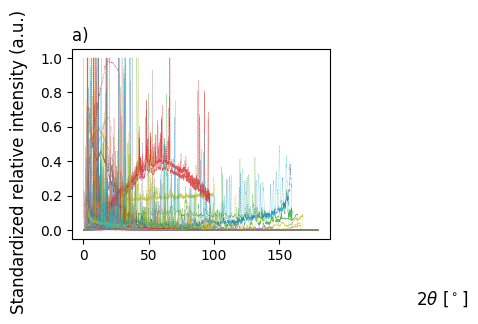

In [4]:
analyser.plot_in_single(limit_patterns=50)

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

/home/daniel/aimat/opxrd/opxrd/analysis/plot.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right', ncols=2, fontsize='small')


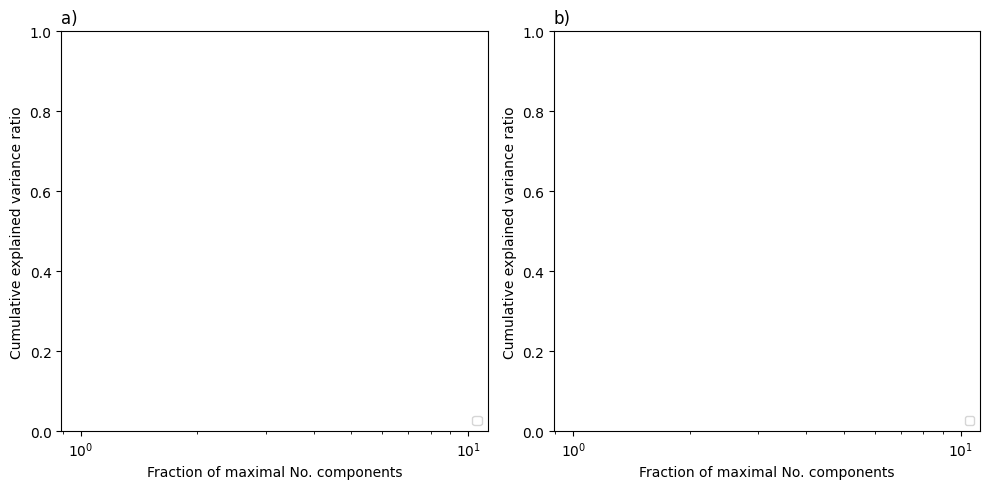

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

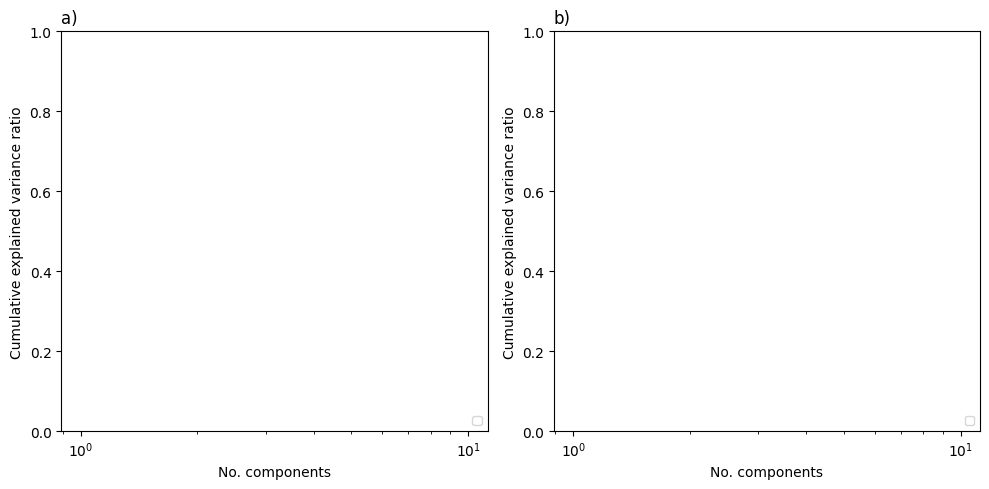

In [5]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

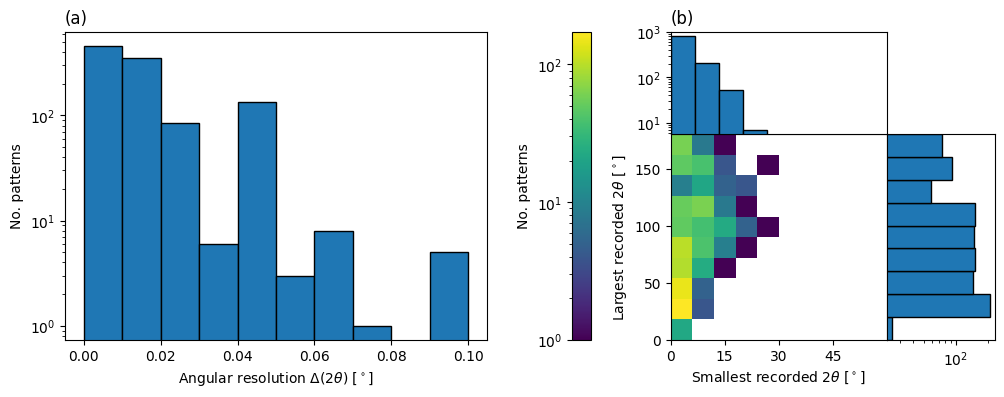

---> Histograms detailing properties of all patterns in the opXRD database: a) distribution of angular resolu-tion in all data; b) distribution of smallest and largest recorded 2θ values for all data.

In [6]:
analyser.xrd_histogram()
analyser.print_text(f'---> Histograms detailing properties of all patterns in the opXRD database: a) distribution of angular resolu-tion in all data; b) distribution of smallest and largest recorded 2θ values for all data.')

ValueError: Pattern Ba4 Sr4 Mo4 O16 has no primary phase

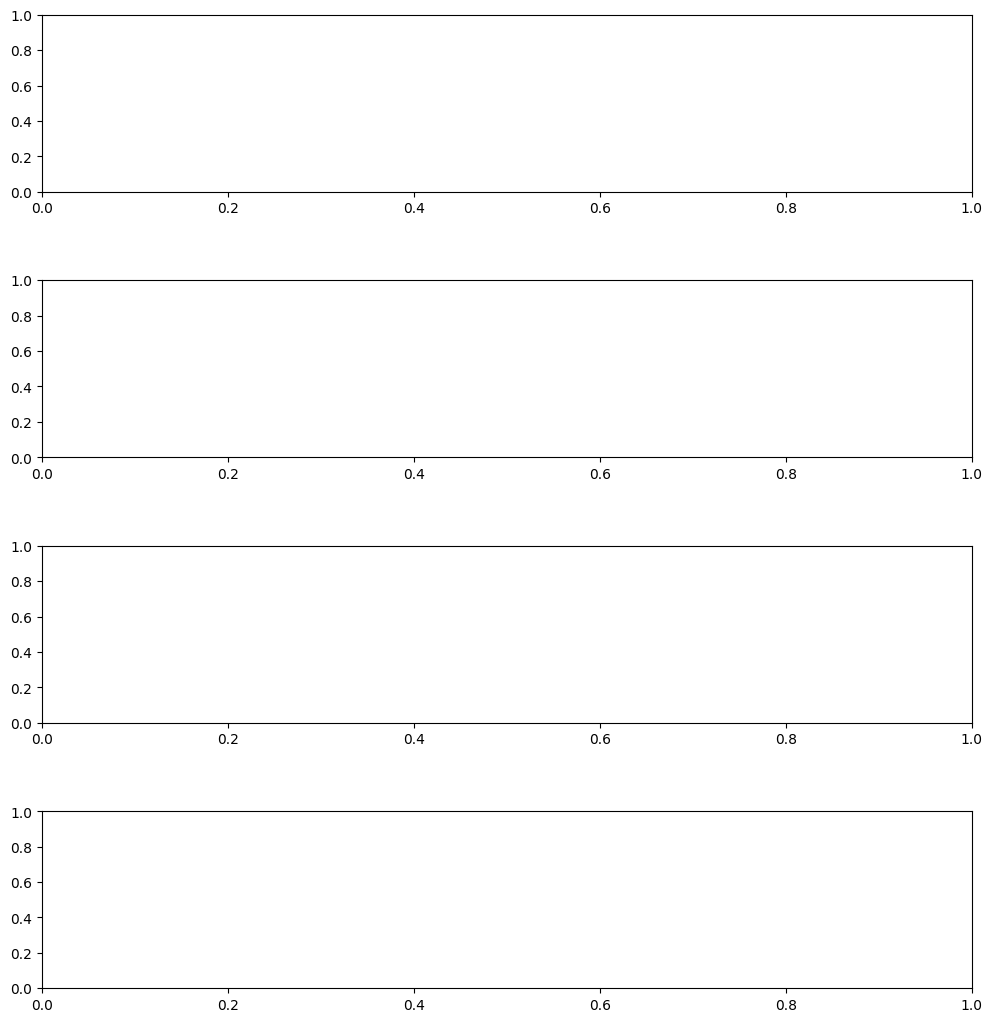

In [7]:
analyser.structure_histogram()
analyser.print_text(f'---> Histograms detailing properties of labeled patterns in the opXRD database: '
                    f'a) distribution of elements occuring in samples;'
                    r'b) distribution of spacegroups; c) distribution of No. atoms N_{\text{atom}}; '
                    r'd) distribution of unit cell volume V_{\text{uc}}')